### CREDIT

This notebook is prepared by the guidance of  Margaret Maynard-Reid's blogs from Pyimagesearch. Most of the code blocks and explanations are taken from these blogs. You can reach original codes and detailed explanations from references.

#### WHAT IS THIS NOTEBOOK

This notebook is an example about DCGAN by keras and TF. We will implement DCGAN for fashion MNIST , based on the paper, Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (Radford et al., 2016).


#### Keywords

* DCGAN
* GAN
* TF 
* MNIST fashion
* Transfer Learning

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

In [2]:
# load the Fashion MNIST dataset and it's OK to use just the training data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
type(train_images)

numpy.ndarray

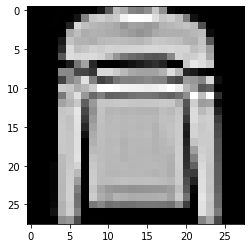

In [5]:
plt.figure()
plt.imshow(train_images[5], cmap='gray')
plt.show()

In [6]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5  

(60000, 28, 28)
(60000, 28, 28, 1)


!!! normalization is between -1 and 1 because of the last layer of the generator.. We are following the article and it guides to use tanh at the last layer of G.

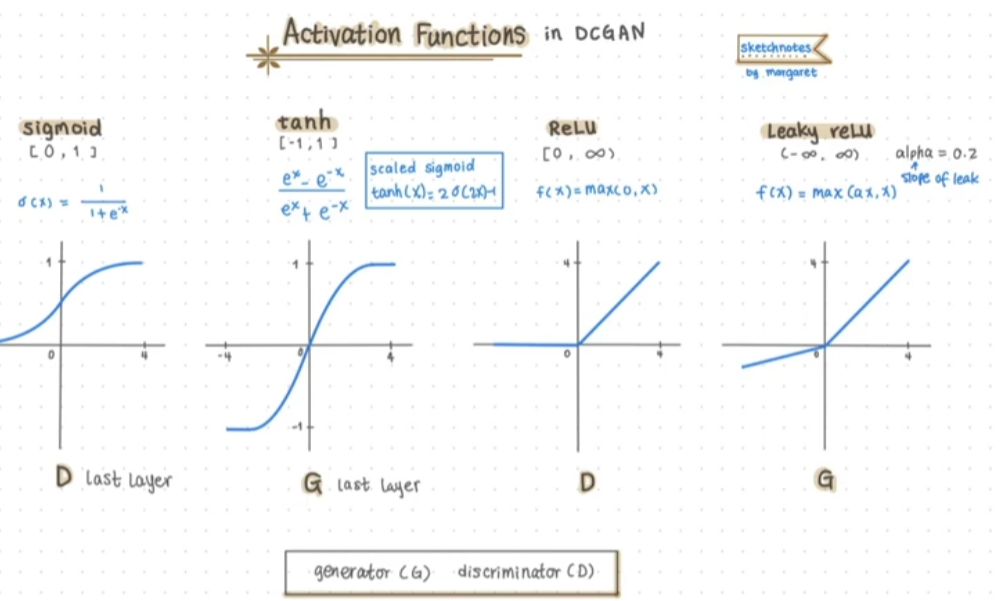

Define the generator model architecture with the Keras. Generator will make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 28x28x1.

In [7]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [8]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((7, 7, 256)))

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    # return the generator model
    return model

In [9]:
# build the generator model
generator = build_generator() 

In [10]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      51

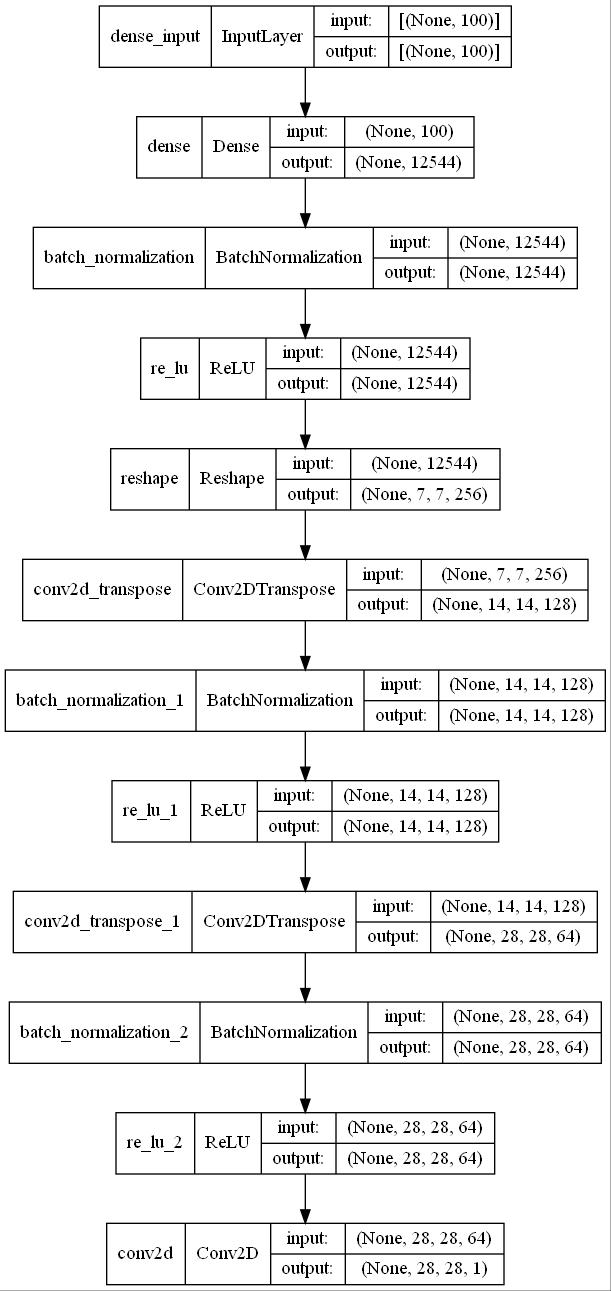

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(generator, show_shapes=True, show_layer_names=True, to_file='generator_DCGAN_fasMNIST.jpg')

Define the discriminator model architecture with the Keras

In [12]:
def build_discriminator(width, height, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    # first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", 
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputs a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [13]:
# build the discriminator model
discriminator = build_discriminator(28, 28, 1) 

In [14]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)       

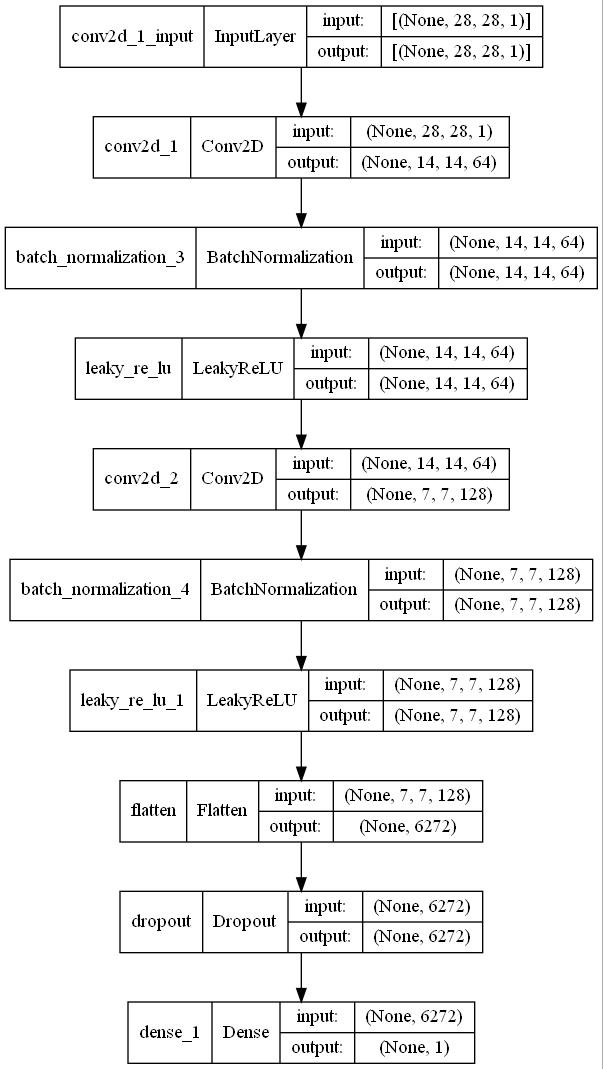

In [15]:
plot_model(discriminator, show_shapes=True, show_layer_names=True, to_file='discriminator_DCGAN_fasMNIST.jpg')


The discriminator loss includes both the loss from the real images and the loss from the fake images.
The generator loss is calculated with thefake images.

In [16]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [17]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator_fash_MNIST.h5')

In [18]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [21]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.3048 - g_loss: 1.1297

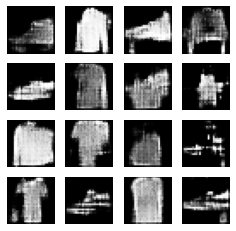

1875/1875 [==============================] - 53s 23ms/step - d_loss: 0.3049 - g_loss: 1.1297
Epoch 2/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6219 - g_loss: 0.8465

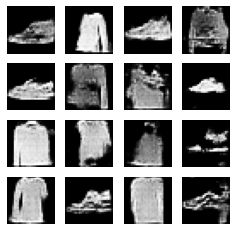

1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6219 - g_loss: 0.8465
Epoch 3/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6604 - g_loss: 0.8771

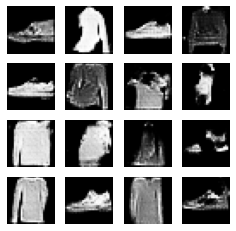

1875/1875 [==============================] - 43s 23ms/step - d_loss: 0.6604 - g_loss: 0.8772
Epoch 4/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6664 - g_loss: 0.8439

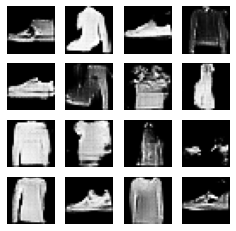

1875/1875 [==============================] - 44s 23ms/step - d_loss: 0.6664 - g_loss: 0.8439
Epoch 5/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6724 - g_loss: 0.8324

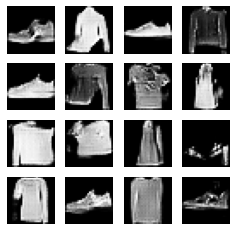

1875/1875 [==============================] - 45s 24ms/step - d_loss: 0.6724 - g_loss: 0.8323
Epoch 6/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6724 - g_loss: 0.8177

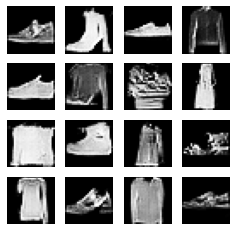

1875/1875 [==============================] - 51s 27ms/step - d_loss: 0.6724 - g_loss: 0.8177
Epoch 7/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6722 - g_loss: 0.8074

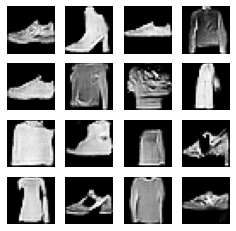

1875/1875 [==============================] - 50s 27ms/step - d_loss: 0.6722 - g_loss: 0.8074
Epoch 8/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6710 - g_loss: 0.8072

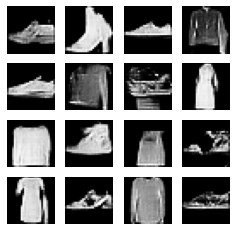

1875/1875 [==============================] - 55s 29ms/step - d_loss: 0.6710 - g_loss: 0.8072
Epoch 9/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6738 - g_loss: 0.8035

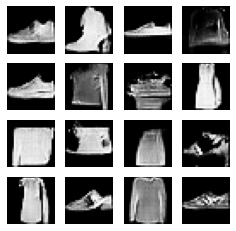

1875/1875 [==============================] - 54s 29ms/step - d_loss: 0.6738 - g_loss: 0.8035
Epoch 10/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6723 - g_loss: 0.8061

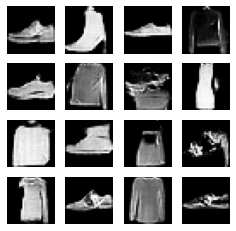

1875/1875 [==============================] - 54s 29ms/step - d_loss: 0.6723 - g_loss: 0.8062
Epoch 11/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6713 - g_loss: 0.8057

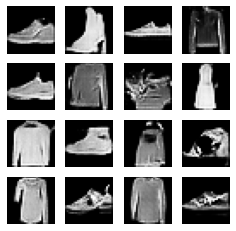

1875/1875 [==============================] - 54s 29ms/step - d_loss: 0.6713 - g_loss: 0.8057
Epoch 12/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6724 - g_loss: 0.8037

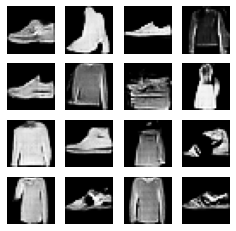

1875/1875 [==============================] - 57s 30ms/step - d_loss: 0.6724 - g_loss: 0.8037
Epoch 13/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6713 - g_loss: 0.8045

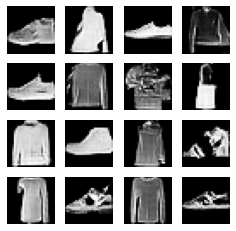

1875/1875 [==============================] - 55s 30ms/step - d_loss: 0.6713 - g_loss: 0.8045
Epoch 14/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6706 - g_loss: 0.8098 ETA: 0s - d_loss: 0.6707 - g_lo

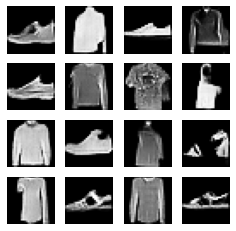

1875/1875 [==============================] - 51s 27ms/step - d_loss: 0.6706 - g_loss: 0.8098
Epoch 15/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6721 - g_loss: 0.8087

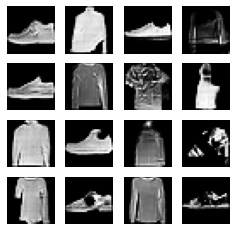

1875/1875 [==============================] - 49s 26ms/step - d_loss: 0.6721 - g_loss: 0.8087
Epoch 16/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6704 - g_loss: 0.8085

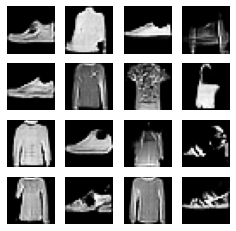

1875/1875 [==============================] - 46s 25ms/step - d_loss: 0.6704 - g_loss: 0.8085
Epoch 17/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6697 - g_loss: 0.8113

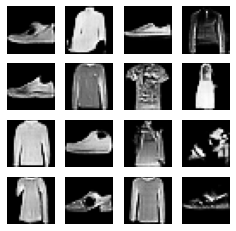

1875/1875 [==============================] - 46s 25ms/step - d_loss: 0.6697 - g_loss: 0.8113
Epoch 18/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6720 - g_loss: 0.8071

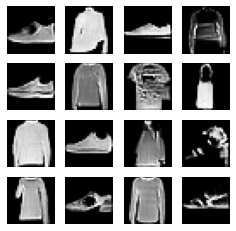

1875/1875 [==============================] - 48s 26ms/step - d_loss: 0.6720 - g_loss: 0.8071
Epoch 19/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6695 - g_loss: 0.8122

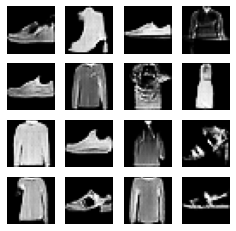

1875/1875 [==============================] - 44s 23ms/step - d_loss: 0.6695 - g_loss: 0.8122
Epoch 20/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6695 - g_loss: 0.8112

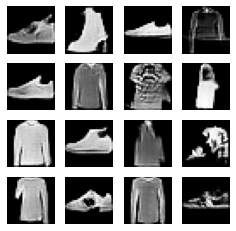

1875/1875 [==============================] - 45s 24ms/step - d_loss: 0.6695 - g_loss: 0.8113
Epoch 21/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6700 - g_loss: 0.8087

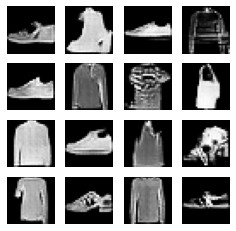

1875/1875 [==============================] - 45s 24ms/step - d_loss: 0.6699 - g_loss: 0.8086
Epoch 22/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6685 - g_loss: 0.8094

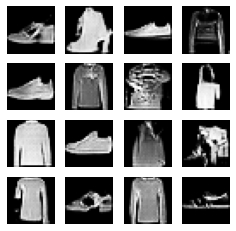

1875/1875 [==============================] - 44s 24ms/step - d_loss: 0.6685 - g_loss: 0.8094
Epoch 23/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6687 - g_loss: 0.8052

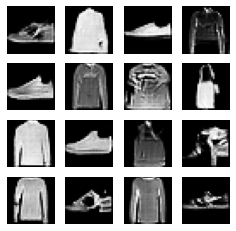

1875/1875 [==============================] - 44s 23ms/step - d_loss: 0.6688 - g_loss: 0.8052
Epoch 24/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6688 - g_loss: 0.8096

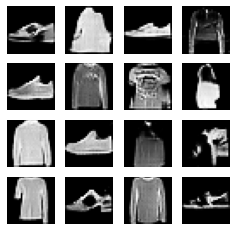

1875/1875 [==============================] - 46s 24ms/step - d_loss: 0.6688 - g_loss: 0.8096
Epoch 25/50
  77/1875 [>.............................] - ETA: 41s - d_loss: 0.6649 - g_loss: 0.8115

KeyboardInterrupt: 

In [24]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

#### !!! It is a time-consuming process... I interrupted the kernel, because my main purpose to show 'how to train'.. I think it is enough

### PART 2_ USE THE GENERATOR

After training, we have a generator model. We will create a noise with (1,100) and use it as an input for our model... And our generator will give us an image of a cloth...Let's see it.

In [26]:
from tensorflow.keras.models import load_model
noise = tf.random.normal(shape=(1, 100))
gen=load_model('generator.h5')

In [28]:
A=gen.predict(noise)

In [32]:
A[0].shape

(28, 28, 1)

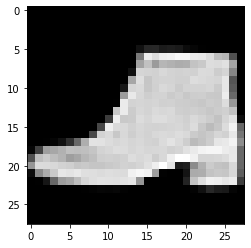

In [33]:
plt.figure()
plt.imshow(A[0], cmap='gray')
plt.show()

Can we define the 'type of cloth'??? for DCGAN, the answer is no, it is not possible...but for CGAN it is an easy step...Check the CGAN notebooks.

REFERENCES : 

Maynard-Reid, M. “Get Started: DCGAN for Fashion-MNIST,” PyImageSearch, 2021, https://pyimagesearch.com/2021/11/11/get-started-dcgan-for-fashion-mnist/

https://arxiv.org/pdf/1511.06434.pdf

